In [ ]:
#pip install pathos
#pip install prophet
import pandas as pd

In [1]:
import sys
sys.path.append(str('/home/jupyter/'))
from configparser import ConfigParser

from repo.MyConfigParser import MyConfigParser

from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts
from repo.FileGenerator import *

In [2]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/US/Jun 2024/config ups us device.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

training_query = config_dict["PROPHETSETTING"]["training_query"]
_input = config_dict["PROPHETSETTING"]["input"]
_output = config_dict["PROPHETSETTING"]["output"]

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]


today = datetime.date.today().strftime("%m.%d.%Y") #'03.10.2023' #
print(today)
base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]

06.06.2024


In [3]:
daily_df = GetBQData(training_query , _input, _output)

/home/jupyter/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


In [4]:
df = daily_df.copy()
df = df.groupby(['market', 'account_type', 'funnel', 'ds']).sum().reset_index()

# log Transformation
# df['cost'] = np.log(df['cost'])
# df.loc[(df['cost'] < 0) | (np.isinf(df['cost'])), 'cost'] = 0

df.ds = pd.to_datetime(df.ds)
df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]

#Combine Tablet and desktop together 
#For November data, use the daily average for that year to fill the missing data

In [5]:
df['ds'] = pd.to_datetime(df['ds'])

In [6]:
# Check for NaN values in the DataFrame
nan_check = daily_df['X'].isna().any()

# Print which columns have NaN values
print(nan_check)

False


In [7]:
 #Filter the data for the year 2022
df_2022 = df[df['ds'].dt.year == 2022]

# Get the unique account types
account_types = df['account_type'].unique()

# Initialize an empty dataframe to store the filled November data
filled_november_data = pd.DataFrame()

# Loop through the unique account types
for account_type in account_types:
    # Filter the data for the current account type
    df_2022_account_type = df_2022[df_2022['account_type'] == account_type]

    # Group the data by day of the month and calculate the mean for X and y columns
    daily_avg_2022 = df_2022_account_type.groupby(df_2022_account_type['ds'].dt.day)[['X', 'y']].mean()

    # Create a new dataframe for November 2022 with date range from 1st to 30th
    november_2022 = pd.date_range(start='2022-11-01', end='2022-11-30', freq='D')
    november_df = pd.DataFrame(november_2022, columns=['ds'])

    # Merge the daily averages with the November dataframe
    filled_november_df = november_df.merge(daily_avg_2022, left_on=november_df['ds'].dt.day, right_index=True)

    # Update the 'ds' column with the correct dates for November 2022
    filled_november_df['ds'] = november_2022

    # Forward-fill the missing values in region, market, funnel, and account_type columns
    filled_november_df[['region', 'market', 'funnel']] = df_2022_account_type[['region', 'market', 'funnel']].fillna(method='ffill').iloc[-1]
    filled_november_df['account_type'] = account_type

    # Append the filled November data for the current account type to the filled_november_data dataframe
    filled_november_data = pd.concat([filled_november_data, filled_november_df], ignore_index=True)

# Append the filled November data to the original dataframe
df_filled = pd.concat([df, filled_november_data], ignore_index=True)

/var/tmp/ipykernel_26913/2767739043.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_november_df[['region', 'market', 'funnel']] = df_2022_account_type[['region', 'market', 'funnel']].fillna(method='ffill').iloc[-1]
/var/tmp/ipykernel_26913/2767739043.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filled_november_df[['region', 'market', 'funnel']] = df_2022_account_type[['region', 'market', 'funnel']].fillna(method='ffill').iloc[-1]
/var/tmp/ipykernel_26913/2767739043.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

In [8]:
df_filled.to_csv(base_path + 'filled_nov.csv')

In [9]:
df_filled['weekday_or_weekend'] = df_filled['ds'].apply(lambda x: 1 if x.dayofweek > 4 else 0)

# set cap and floor for log regression
df_filled['Month of Ds'] = df_filled['ds'].dt.month_name()

df_filled['floor'] = 0

boundary_df = pd.read_csv(base_path + 'Floor Cap Setting Global.csv')
boundary_df.rename(columns = {'Account Type': 'account_type', 'Funnel':'funnel'}, inplace = True)
boundary_df.drop(['Market'], axis = 1, inplace = True)

df_filled = pd.merge(df_filled, boundary_df, on = ['account_type', 'funnel'])
df_filled['cap'] = df_filled.ROAS * df_filled.X / df_filled.AOV
df_filled.loc[df_filled.cap == 0, 'cap'] = df_filled.cap.max()

df_filled.to_csv(base_path + f'Daily Data {today}.csv')

In [37]:
df_filled.to_csv(base_path + 'df_filled.csv')

# Analytical File Generator

In [10]:
#analytical_file_name = 'Analytical_File_Jun.csv'
generator = AnalyticalFileGenerator(config_dict)
analytical_file_df = generator.generate()
analytical_file_df = pd.merge(analytical_file_df, boundary_df, on = ['account_type', 'funnel']) # merge with boundary_df to filter data to only have the splits needed
analytical_file_df.to_csv(analytical_file_path)
#generator.SaveFile(analytical_file_name, folder_name) # X is input value which should be the sum of all variable splits

/home/jupyter/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


In [17]:
cuts_df = pd.read_csv(base_path + region + ' Breakdown feb.csv')#.drop('Unnamed: 0', axis = 1)
cuts_df['periods'] = periods
cuts_df['periods_for_acc_cal'] = 183
cuts_df['cutoff_month'] = cutoff_month
# cuts_df.account_type = 'unified'
cuts_df.loc[cuts_df['account_type'] == 'Desktop', 'input_mode'] = 'additive'
cuts_df.loc[cuts_df['account_type'] == 'Mobile & Tablet', 'input_mode'] = 'multiplicative'

query_item_list = [query_item for query_item in [config_dict["CLIENTINFO"]["breakdown1"], \
                             config_dict["CLIENTINFO"]["breakdown2"], \
                             config_dict["CLIENTINFO"]["breakdown3"], \
                             config_dict["CLIENTINFO"]["breakdown4"]]
                             if query_item != None]

# Accuracy based on previous refresh

generic_df = pd.read_csv("record_df 2023-08-16 18:16:20 best result.csv")
generic_df

In [18]:
calculator = AccuracyCalculator()
# # %load_ext autoreload
# # %autoreload 2
accuracy_df = calculator.CalculateAccuracy(cuts_df, df_filled, query_item_list) # calculate accuracy based on cuts_df previous hyper parameters
#calculator.SaveFile()
calculator.SaveFile(output_bucket, folder_name, 'Accuracy.csv')

16:02:15 - cmdstanpy - INFO - Chain [1] start processing
16:02:15 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/repo/Accuracy.py:268: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.monthly_acc_df_temp = pd.concat([self.monthly_acc_df_temp, monthly_acc_df], ignore_index=True)
16:02:15 - cmdstanpy - INFO - Chain [1] start processing
16:02:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.83 Period MAE: 13.99
It's underpredicted.
Monthly Error: 30.28 Period MAE: 33.379999999999995
Data Frame file saved


In [19]:
accuracy_df.to_csv(base_path + 'test_Acc_feb.csv')

In [20]:
accuracy = accuracy_df.groupby(['account_type']).mean(numeric_only=1) # group by split 
accuracy['Accuracy'] = np.where(accuracy['MAPE'] > 100, 'MAPE above 100%', 100 - accuracy['MAPE']) # create accuracy from MAPE 
accuracy['Forecast Period Accuracy'] = np.where(accuracy['Forecast Period MAE'] > 100, 'Forecast Period MAE above 100%', 100 - accuracy['Forecast Period MAE']) # create period accuracy from period MAPE
accuracy.drop(columns=['MAPE','Forecast Period MAE'], inplace=True) # drop error columns 
accuracy.rename(columns = {'Percentage Error': 'Mean Percentage Error'}, inplace = True) # rename columns
accuracy


,Actual,Forecast,Mean Percentage Error,Accuracy,Forecast Period Accuracy
account_type,,,,,
Desktop,472826.142857,406671.998571,15.911429,62.17,86.01
Mobile & Tablet,8382.857143,5585.054286,30.281429,69.72,66.62


In [16]:
100-accuracy_df.groupby(['market']).mean(numeric_only=1)

,Actual,Forecast,Percentage Error,MAPE,Forecast Period MAE
market,,,,,
US,-240504.5,-262727.828571,91.882857,79.685,80.13


# Parallel Param Search

In [19]:
param_grid = {
    'changepoint_prior_scale': [ 0.1, 0.05, 0.001],   
    'seasonality_prior_scale': [10.0, 1.0, 0.1, 0.01 ], 
    'holidays_prior_scale': [10.0, 1.0,  0.1, 0.01], 
    'seasonality_mode': ['additive','multiplicative'], 
    'input_mode': ['additive','multiplicative'], 
    'weekday_or_weekend':['na', 'additive', 'multiplicative'],  
    'include_holiday': ['na', 'Default', 'Custom'],
    'covid_year_exclude':['na'],
    'covid_year_dummy':['na'],#, 'additive', 'multiplicative'],
    'anomaly_2021':['na'],#, 'additive', 'multiplicative'],
    'generic_cost_split':['na'],#, 'additive', 'multiplicative'
    'competitor_cost_split':['na'], #, 'additive', 'multiplicative'
    'new_confirmed': ['na'],#, 'additive', 'multiplicative'
            }


In [20]:
cuts_df_mobile= cuts_df.loc[cuts_df['account_type'] == 'Mobile & Tablet'] 

cuts_df_desktop = cuts_df.loc[cuts_df['account_type'] == 'Desktop'] 
cuts_df_desktop

,market,account_type,funnel,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,...,covid_year_exclude,covid_year_dummy,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,periods,cutoff_month
0,US,Desktop,-,183,0.05,0.1,1.0,multiplicative,additive,na,...,na,na,na,na,na,na,na,logistic,251.0,2024-04-25


In [22]:
# Load the autoreload extension
#%load_ext autoreload
# Set autoreload mode to 2, which reloads all modules before executing code
#%autoreload 2
search_engine = ProphetParameterSearch(param_grid = param_grid,power_flag = False, base_path=base_path) # , logistic_flag = False
grid_brand = search_engine.search(cuts_df_mobile, df_filled)


100%|██████████| 1/1 [28:59<00:00, 1739.24s/it]


In [26]:
df_best_desktop = pd.read_csv('record_df 2024-05-29 17:02:37 best result.csv')
df_best_mobile = pd.read_csv('record_df 2024-05-29 17:33:41 best result.csv')

# Append the second dataframe to the first one
combined_best_df = pd.concat([df_best_desktop, df_best_mobile], ignore_index=True)

#Save the combined dataframe to a new CSV file
combined_best_df.to_csv('Breakdown Jun final_v2.csv', index=False)
combined_best_df

,Unnamed: 0,market,account_type,funnel,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,...,covid_year_exclude,covid_year_dummy,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,MAPE,period_AE
0,0,US,Desktop,-,183,0.05,10.00,1.0,multiplicative,multiplicative,...,na,na,na,na,na,na,na,logistic,7.99,0.88
1,0,US,Mobile & Tablet,-,183,0.10,0.01,10.0,multiplicative,multiplicative,...,na,na,na,na,na,na,na,linear,12.48,11.03


In [ ]:
# Update new_cuts_df with new hyper parameters

In [44]:
df_for_plt = accuracy_df.drop(['Actual', 'Forecast', 'MAPE', 'Forecast Period MAE', 'Predict Status'], axis=1).pivot(index = 'Month', columns = (query_item_list), values = 'Percentage Error')

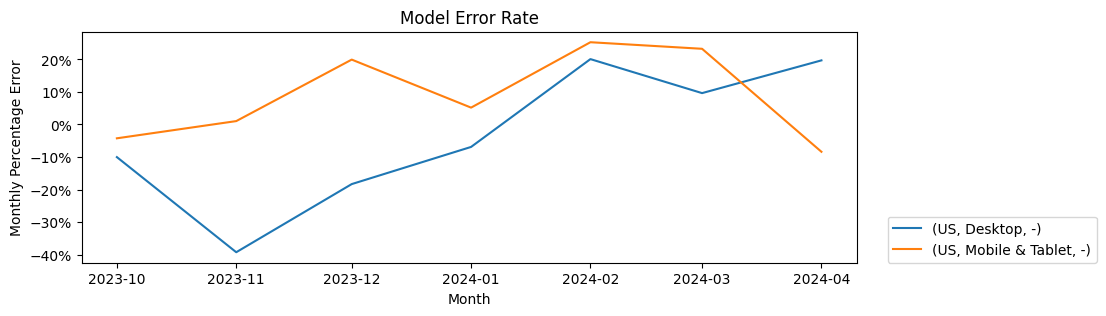

In [45]:
plot_printer = PlotAndSaveAccuracyDf()
fig = plot_printer.Plot(df_for_plt)
plot_name = "Accuracy_By_Month.jpg"
%load_ext autoreload
%autoreload 2

In [46]:
#fig.savefig(plot_name)
plot_printer.SaveToGCS(output_bucket,  plot_name, folder_name)

ups_bj_cost_by_device_optimization//US/Jun 2024/Accuracy_By_Month.jpg
Image saved: ups_bj_cost_by_device_optimization//US/Jun 2024/Accuracy_By_Month.jpg


# Model Generator

In [47]:
%load_ext autoreload
%autoreload 2
model_generator = GenerateModelFile()
model_generator.Generate(cuts_df, df_filled, query_item_list, output_bucket, folder_name)

22:09:23 - cmdstanpy - INFO - Chain [1] start processing


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


22:09:23 - cmdstanpy - INFO - Chain [1] done processing
22:09:24 - cmdstanpy - INFO - Chain [1] start processing
22:09:24 - cmdstanpy - INFO - Chain [1] done processing


# Constraint Setting

In [48]:
bounds = cuts_df.copy()
bounds['MinWeight'] = 0.8
bounds['MaxWeight'] = 1.2
bounds

# %load_ext autoreload
# %autoreload 2
constraint_file_generator = ConstraintFileGenerator(config_dict, analytical_file_df)
constraint_file = constraint_file_generator.Generate(bounds)

constraint_file.loc[constraint_file['Month'].isin(['Nov']), 'MinWeight'] = 0.7
constraint_file.loc[constraint_file['Month'].isin(['Nov']), 'MaxWeight'] = 0.8

constraint_file_generator.SaveFile(output_bucket, folder_name, constraint_file_name)

Data Frame file saved


In [49]:
constraint_file

,market,account_type,funnel,Month,Year,variable_splits,Constrain_Variable_Name,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,...,competitor_cost_split,new_confirmed,power,growth,MAPE,period_AE,periods,cutoff_month,MinWeight,MaxWeight
0,US,Desktop,-,Apr,2024,US_Desktop_-_Apr_2024,cost,183,0.05,10.00,...,na,na,na,logistic,7.99,0.88,251.0,2024-04-25,0.8,1.2
1,US,Desktop,-,May,2024,US_Desktop_-_May_2024,cost,183,0.05,10.00,...,na,na,na,logistic,7.99,0.88,251.0,2024-04-25,0.8,1.2
2,US,Desktop,-,Jun,2024,US_Desktop_-_Jun_2024,cost,183,0.05,10.00,...,na,na,na,logistic,7.99,0.88,251.0,2024-04-25,0.8,1.2
3,US,Desktop,-,Jul,2024,US_Desktop_-_Jul_2024,cost,183,0.05,10.00,...,na,na,na,logistic,7.99,0.88,251.0,2024-04-25,0.8,1.2
4,US,Desktop,-,Aug,2024,US_Desktop_-_Aug_2024,cost,183,0.05,10.00,...,na,na,na,logistic,7.99,0.88,251.0,2024-04-25,0.8,1.2
5,US,Desktop,-,Sep,2024,US_Desktop_-_Sep_2024,cost,183,0.05,10.00,...,na,na,na,logistic,7.99,0.88,251.0,2024-04-25,0.8,1.2
6,US,Desktop,-,Oct,2024,US_Desktop_-_Oct_2024,cost,183,0.05,10.00,...,na,na,na,logistic,7.99,0.88,251.0,2024-04-25,0.8,1.2
7,US,Desktop,-,Nov,2024,US_Desktop_-_Nov_2024,cost,183,0.05,10.00,...,na,na,na,logistic,7.99,0.88,251.0,2024-04-25,0.7,0.8
8,US,Desktop,-,Dec,2024,US_Desktop_-_Dec_2024,cost,183,0.05,10.00,...,na,na,na,logistic,7.99,0.88,251.0,2024-04-25,0.8,1.2
9,US,Mobile & Tablet,-,Apr,2024,US_Mobile_&_Tablet_-_Apr_2024,cost,183,0.10,0.01,...,na,na,na,linear,12.48,11.03,251.0,2024-04-25,0.8,1.2
